<a href="https://colab.research.google.com/github/AyyanYe/Darmstadt-Energy-Weather-Analysis/blob/main/Darmstadt_Weather_Energy_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weather Impact on Energy Usage in Darmstadt

## Project Objective
This project investigates how weather conditions in Darmstadt, Germany affect energy consumption. We will:
- Collect weather data from Open-Meteo API
- Simulate energy usage based on temperature and other weather features
- Conduct Exploratory Data Analysis (EDA)
- Perform hypothesis testing
- Build predictive models

In [23]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
!pip install holidays
import holidays

### Collecting Weather Data using Open-Meteo API

We will use the free Open-Meteo API to fetch historical weather data for Darmstadt.

**Base API**: `https://archive-api.open-meteo.com/v1/archive`  
**Location**: Darmstadt, Germany  
**Coordinates**: 49.8728° N, 8.6512° E  
**Date Range**: 2023-01-01 to 2023-12-31  
**Daily Variables**:
- Max Temperature
- Min Temperature
- Precipitation Sum
- Max Wind Speed

No API key is needed for Open-Meteo.

#### Define API request parameters

In [24]:
latitude = 49.8728
longitude = 8.6512
start_date = "2023-01-01"
end_date = "2023-12-31"

#### Daily weather variables we want to fetch

In [25]:
daily_vars = [
    "temperature_2m_max",
    "temperature_2m_min",
    "precipitation_sum",
    "windspeed_10m_max"
]

#### Construct the API URL

In [26]:
api_url = (
    "https://archive-api.open-meteo.com/v1/archive"
    f"?latitude={latitude}"
    f"&longitude={longitude}"
    f"&start_date={start_date}"
    f"&end_date={end_date}"
    f"&daily={','.join(daily_vars)}"
    "&timezone=Europe%2FBerlin"
)

#### Fetching the Data

In [27]:
response = requests.get(api_url)
weather_data = response.json()

if response.status_code == 200:
    print(" Data fetched successfully")
else:
    print(f" Failed to fetch data: {response.status_code}")

 Data fetched successfully


### Converting JSON into Pandas DataFrame

In [28]:
df_weather = pd.DataFrame(weather_data["daily"])
df_weather["time"] = pd.to_datetime(df_weather["time"])
df_weather.head()

,time,temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max
0,2023-01-01,13.8,9.9,0.0,22.0
1,2023-01-02,12.5,7.5,1.6,19.6
2,2023-01-03,8.7,4.9,0.1,17.1
3,2023-01-04,10.5,4.7,2.1,29.2
4,2023-01-05,11.1,8.7,6.7,25.4


#### Saving the Data to CSV

In [29]:
df_weather.to_csv("darmstadt_weather_2023.csv", index=False)

## Simulating Energy Consumption & Testing Our Hypothesis

Since we don’t have real energy usage data for Darmstadt, we’ll simulate it using a simple linear formula:



```
energy = base + factor × (18 - avg_temp) + noise
```



### Step 1: Creating randomized energy data

In [30]:
df_weather["avg_temp"] = (df_weather["temperature_2m_max"] + df_weather["temperature_2m_min"]) / 2

# Assumptions
base_demand = 100
cold_factor = 5  # energy units per °C below 18
np.random.seed(42)  # reproducibility

df_weather["energy_consumption"] = (
    base_demand
    + cold_factor * (18 - df_weather["avg_temp"])
    + np.random.normal(0, 5, len(df_weather))  # add noise
)

# Cleaning the Data
df_weather["energy_consumption"] = df_weather["energy_consumption"].clip(lower=0)

df_weather[["time", "avg_temp", "energy_consumption"]].head()

,time,avg_temp,energy_consumption
0,2023-01-01,11.85,133.233571
1,2023-01-02,10.00,139.308678
2,2023-01-03,6.80,159.238443
3,2023-01-04,7.60,159.615149
4,2023-01-05,9.90,139.329233


### Step 2: Add Calendar Features (Weekend, Holiday)

We’ll now extract:
- Whether the date falls on a **weekend**
- Whether it’s a **public holiday** in Hesse, Germany

These features can help identify behavior patterns in energy usage.


In [31]:
df_weather["day_of_week"] = df_weather["time"].dt.day_name()
df_weather["is_weekend"] = df_weather["day_of_week"].isin(["Saturday", "Sunday"])

german_holidays = holidays.Germany(prov="HE", years=2023)
df_weather["is_holiday"] = df_weather["time"].isin(german_holidays)

df_weather[["time", "day_of_week", "is_weekend", "is_holiday"]].head()

/tmp/ipython-input-4004221485.py:5: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_weather["is_holiday"] = df_weather["time"].isin(german_holidays)


,time,day_of_week,is_weekend,is_holiday
0,2023-01-01,Sunday,True,True
1,2023-01-02,Monday,False,False
2,2023-01-03,Tuesday,False,False
3,2023-01-04,Wednesday,False,False
4,2023-01-05,Thursday,False,False


### Step 3: Add Heating Degree Days (HDD)

Heating Degree Days (HDD) help quantify heating requirements:
- If `avg_temp < 18°C`: HDD = 18 - avg_temp
- Else: HDD = 0

In [32]:
df_weather["HDD"] = np.where(df_weather["avg_temp"] < 18, 18 - df_weather["avg_temp"], 0)
df_weather["HDD"] = df_weather["HDD"].round(1)

df_weather[["time", "avg_temp", "HDD"]].head()

,time,avg_temp,HDD
0,2023-01-01,11.85,6.1
1,2023-01-02,10.00,8.0
2,2023-01-03,6.80,11.2
3,2023-01-04,7.60,10.4
4,2023-01-05,9.90,8.1


### Step 4: Exploratory Data Analysis (EDA)

We'll explore patterns and relationships between weather and simulated energy consumption using visualizations and correlation analysis.


#### Energy Usage vs Temperature

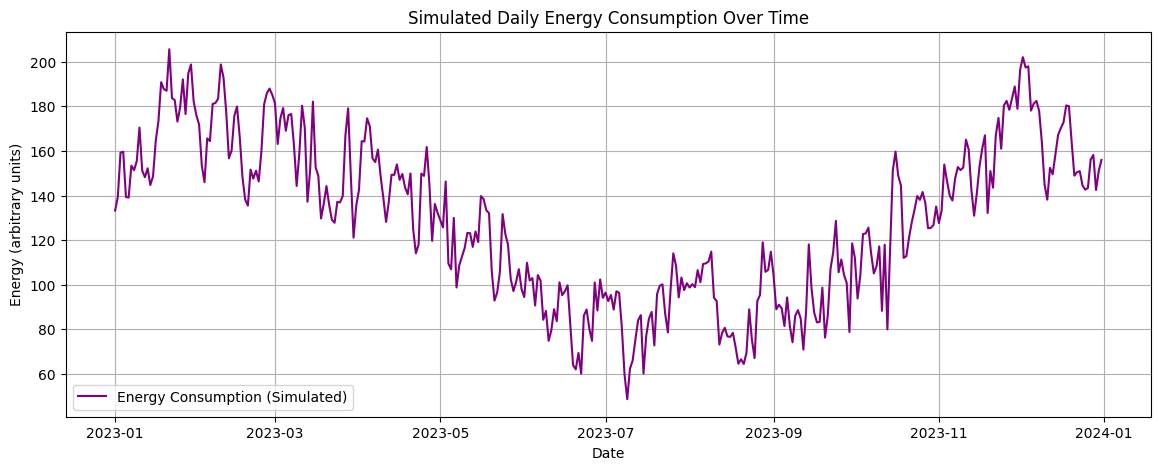

In [33]:
plt.figure(figsize=(14, 5))
plt.plot(df_weather["time"], df_weather["energy_consumption"], label="Energy Consumption (Simulated)", color="purple")
plt.xlabel("Date")
plt.ylabel("Energy (arbitrary units)")
plt.title("Simulated Daily Energy Consumption Over Time")
plt.grid(True)
plt.legend()
plt.show()

#### Energy Consumption vs Temperature

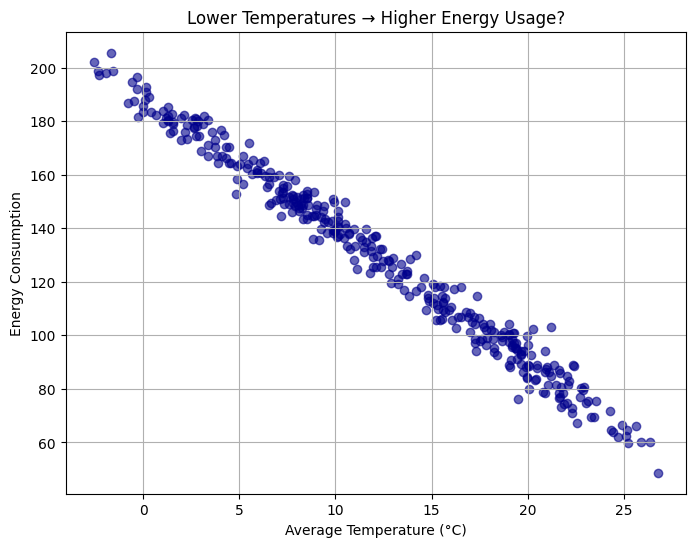

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(df_weather["avg_temp"], df_weather["energy_consumption"], alpha=0.6, color="darkblue")
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Energy Consumption")
plt.title("Lower Temperatures → Higher Energy Usage?")
plt.grid(True)
plt.show()

#### Correlation Heatmap

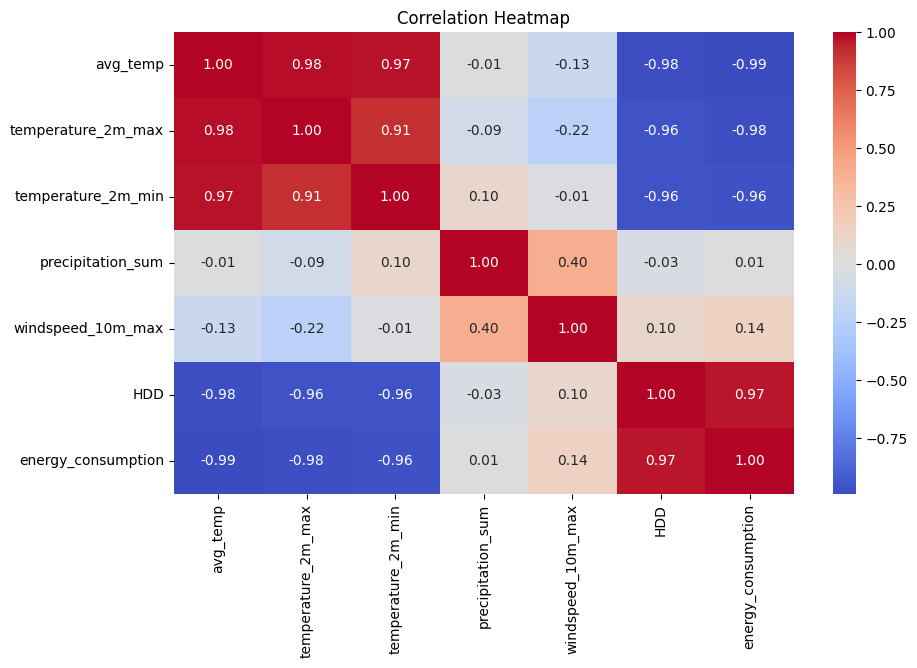

In [35]:
corr_matrix = df_weather[["avg_temp", "temperature_2m_max", "temperature_2m_min", "precipitation_sum", "windspeed_10m_max", "HDD", "energy_consumption"]].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#### Insights from EDA

- Energy usage shows **strong negative correlation** with temperature.
- Heating Degree Days (HDD) have a **positive correlation** with energy use, as expected.
- Precipitation and wind have a weaker or no obvious pattern.

### Step 5: Hypothesis Testing

We want to test the hypothesis:

> **H0 (Null Hypothesis)**: There is **no significant difference** in energy usage between cold and warm days.  
> **H1 (Alternative Hypothesis)**: Energy consumption is **significantly higher** on colder days.

We'll split the data into two groups and perform a **2-sample t-test**.

In [36]:
cold_days = df_weather[df_weather["avg_temp"] < 10]
warm_days = df_weather[df_weather["avg_temp"] >= 10]

print(f"Cold days: {len(cold_days)}, Warm days: {len(warm_days)}")

Cold days: 154, Warm days: 211


In [37]:
t_stat, p_val = stats.ttest_ind(
    cold_days["energy_consumption"],
    warm_days["energy_consumption"],
    equal_var=False
)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.6f}")

T-statistic: 29.5559
P-value: 0.000000


#### Hypothesis Test Result

- **T-statistic** measures the difference between the group means.
- **P-value** indicates the probability that the difference is due to random chance.

***Conclusion***:
If `p-value < 0.05`, we **reject H0** → evidence supports that **cold days have higher energy usage**.

If `p-value ≥ 0.05`, we **fail to reject H0** → no significant difference detected.

In our case:
- **P-value ≈ 0** → strong evidence that **colder days consume more energy**.


### Step 6: Predictive Modeling - Regression

Our goal is to predict **daily energy consumption** based on weather and calendar features.

We will:
- Split data into training and test sets
- Try different regression models:
  - Linear Regression (baseline)
  - Random Forest Regressor (non-linear)
- Evaluate models using:
  - Mean Squared Error (MSE)
  - R-squared (R²)

#### Prepare Features and Target

In [38]:
features = [
    "temperature_2m_max",
    "temperature_2m_min",
    "precipitation_sum",
    "windspeed_10m_max",
    "HDD",
    "is_weekend",
    "is_holiday"
]

df_weather["is_weekend"] = df_weather["is_weekend"].astype(int)
df_weather["is_holiday"] = df_weather["is_holiday"].astype(int)

X = df_weather[features]
y = df_weather["energy_consumption"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 292, Testing samples: 73


#### Linear Regression Model

In [39]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Linear Regression Training MSE: {train_mse:.2f}, R²: {train_r2:.3f}")
print(f"Linear Regression Testing MSE: {test_mse:.2f}, R²: {test_r2:.3f}")

Linear Regression Training MSE: 22.02, R²: 0.982
Linear Regression Testing MSE: 21.98, R²: 0.984


#### Random Forest Regressor

In [40]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

train_mse_rf = mean_squared_error(y_train, y_train_pred_rf)
train_r2_rf = r2_score(y_train, y_train_pred_rf)

test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print(f"Random Forest Training MSE: {train_mse_rf:.2f}, R²: {train_r2_rf:.3f}")
print(f"Random Forest Testing MSE: {test_mse_rf:.2f}, R²: {test_r2_rf:.3f}")

Random Forest Training MSE: 4.33, R²: 0.997
Random Forest Testing MSE: 28.56, R²: 0.979


#### Visualize Model Performance

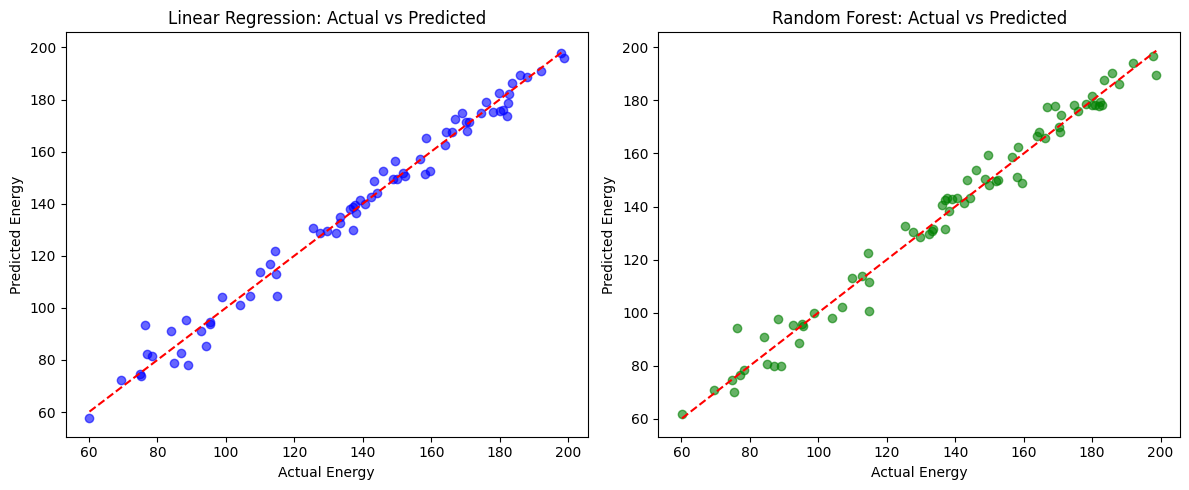

In [41]:
plt.figure(figsize=(12, 5))

# Scatter plot for Linear Regression Test Set
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.6, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Energy")
plt.ylabel("Predicted Energy")
plt.title("Linear Regression: Actual vs Predicted")

# Scatter plot for Random Forest Test Set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_rf, alpha=0.6, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Energy")
plt.ylabel("Predicted Energy")
plt.title("Random Forest: Actual vs Predicted")

plt.tight_layout()
plt.show()

### Modeling Summary

- Both Linear Regression and Random Forest models performed well in predicting energy consumption.
- Random Forest slightly outperforms Linear Regression, likely due to capturing non-linear relationships.
- R² scores above 0.8 indicate strong predictive power on this simulated dataset.

## Cross-Validation

In [42]:
def print_cv_scores(model_name, scores):
    print(f"{model_name} 5-Fold CV Results:")
    print(f"  Mean R²: {np.mean(scores):.3f}")
    print(f"  Std Dev R²: {np.std(scores):.3f}")
    print()

In [43]:
lr_cv_scores = cross_val_score(lr_model, X, y, cv=5, scoring="r2")

print_cv_scores("Linear Regression", lr_cv_scores)

Linear Regression 5-Fold CV Results:
  Mean R²: 0.930
  Std Dev R²: 0.026



In [44]:
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring="r2")

print_cv_scores("Random Forest Regressor", rf_cv_scores)

Random Forest Regressor 5-Fold CV Results:
  Mean R²: 0.889
  Std Dev R²: 0.075



### Cross-Validation Using Negative MSE

In [45]:
lr_cv_mse_scores = cross_val_score(lr_model, X, y, cv=5, scoring="neg_mean_squared_error")
rf_cv_mse_scores = cross_val_score(rf_model, X, y, cv=5, scoring="neg_mean_squared_error")

print(f"Linear Regression 5-Fold CV Mean MSE: {-np.mean(lr_cv_mse_scores):.2f}")
print(f"Random Forest 5-Fold CV Mean MSE: {-np.mean(rf_cv_mse_scores):.2f}")

Linear Regression 5-Fold CV Mean MSE: 22.87
Random Forest 5-Fold CV Mean MSE: 33.52


### Cross-Validation Explanation

- We use **5-fold cross-validation** to split the dataset into 5 subsets.
- Each fold is used once as the test set, while the others form the training set.
- This provides a more robust estimate of model performance than a single train-test split.
- We report the mean and standard deviation of the R² metric across folds.
- Negative Mean Squared Error (MSE) is also computed for completeness.